In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
import nltk.classify.util
from nltk.corpus import stopwords
from nltk.classify import NaiveBayesClassifier
from nltk.tokenize import word_tokenize
import IPython
import re
from bs4 import BeautifulSoup

In [2]:
plt.style.use('fivethirtyeight') #538

#the %matplotlib inline will make our plot outputs appear and be stored within the notebook.
#%matplotlib.inline  

#For anyone stumbling across this, as of PR #3381, you can now enable 2x images by just adding the line:
%config InlineBackend.figure_format = 'retina'

In [3]:
# reading the dataset .csv file
cols = ['sentiment','id','date','query_string','user','text']
dataframe = pd.read_csv("training_data.csv", header=None ,names=cols )
dataframe.head()

,sentiment,id,date,query_string,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [4]:
dataframe.describe()

,sentiment,id
count,1.600000e+06,1.600000e+06
mean,2.000000e+00,1.998818e+09
std,2.000001e+00,1.935761e+08
min,0.000000e+00,1.467810e+09
25%,0.000000e+00,1.956916e+09
50%,2.000000e+00,2.002102e+09
75%,4.000000e+00,2.177059e+09
max,4.000000e+00,2.329206e+09


In [5]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 6 columns):
sentiment       1600000 non-null int64
id              1600000 non-null int64
date            1600000 non-null object
query_string    1600000 non-null object
user            1600000 non-null object
text            1600000 non-null object
dtypes: int64(2), object(4)
memory usage: 73.2+ MB


In [6]:
#by closely watching the dataset we get to know that id , data , query_string , user are of no use 
# axis = 1 mean column
dataframe= dataframe.drop(['id','date','query_string','user'],axis=1)
dataframe[dataframe.sentiment == 0].index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            799990, 799991, 799992, 799993, 799994, 799995, 799996, 799997,
            799998, 799999],
           dtype='int64', length=800000)

In [7]:
dataframe.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [8]:
dataframe['pre_clean_len'] = [len(t) for t in dataframe.text]

In [9]:
dataframe.head()

,sentiment,text,pre_clean_len
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",115
1,0,is upset that he can't update his Facebook by ...,111
2,0,@Kenichan I dived many times for the ball. Man...,89
3,0,my whole body feels itchy and like its on fire,47
4,0,"@nationwideclass no, it's not behaving at all....",111


In [10]:
max(dataframe.pre_clean_len)

374

In [11]:
# since the max no of character in the twitter can be 140 but here it is 374  that is the 
# the text is not clean we need to clean it 

#cleaning HTML tags using BS4
dataframe.text[279]
# output-- "Whinging. My client&amp;boss don't understand English well. 
# Rewrote some text unreadable. It's written by v. good writer&amp;reviewed correctly. "
ex = BeautifulSoup(dataframe.text[279],'lxml')
ex.get_text()
# output -- u"Whinging. My client&boss don't understand English well.
# Rewrote some text unreadable. It's written by v. good writer&reviewed correctly. "

#cleaning @mentions because they are not usefull
dataframe.text[343]
# output-- '@TheLeagueSF Not Fun &amp; Furious? The new mantra for the Bay 2 Breakers? 
# It was getting 2 rambunctious;the city overreacted &amp; clamped down '
re.sub(r'@[a-zA-Z0-9]+','',dataframe.text[343])
# output -- ' Not Fun &amp; Furious? The new mantra for the Bay 2 Breakers? 
# It was getting 2 rambunctious;the city overreacted &amp; clamped down '

#removing URL links
dataframe.text[0]
# output-- "@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"
re.sub(r'https?://[a-zA-Z0-9./]+','',dataframe.text[0])
# "@switchfoot  - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D"
# removing non ascii char
dataframe.text[226].decode('UTF-8')
re.sub(u'\ufffd',' ',dataframe.text[226].decode("UTF-8"))

# tough #_tag are important so we cant remove words withs #_tags but we can remove the pucn tuations #
dataframe.text[175]
re.sub(r'[^a-zA-za]',' ',dataframe.text[175])

' machineplay I m so sorry you re having to go through this  Again    therapyfail'

In [12]:
#cleaning our dataset
combine_mention_and_URLs = r'@[A-za-z0-9]+|https?://[a-zA-Z0-9./]+'

#dealing with web links like www.
ww_remov = r'www.[^ ]+'

negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner(text):
    soup = BeautifulSoup(text,'lxml')
    souped = soup.get_text()
    stripped = re.sub(combine_mention_and_URLs,'',souped)
    stripped = re.sub(ww_remov, '', stripped)
    
    try:
        clean = stripped.decode("utf-8").replace(u"fffd"," ")
    except:
        clean = stripped
    
    lowercase = clean.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lowercase)
    letters_only = re.sub(r"[^a-zA-Z]"," ",neg_handled)
    words = word_tokenize(letters_only)
    return (" ".join(words)).strip()

In [13]:
testing = dataframe.text[:10]
test_rsult = []
for t in testing:
    test_rsult.append(tweet_cleaner(t))
test_rsult[:10]

[u'awww that s a bummer you shoulda got david carr of third day to do it d',
 u'is upset that he can not update his facebook by texting it and might cry as a result school today also blah',
 u'i dived many times for the ball managed to save the rest go out of bounds',
 u'my whole body feels itchy and like its on fire',
 u'no it s not behaving at all i m mad why am i here because i can not see you all over there',
 u'not the whole crew',
 u'need a hug',
 u'hey long time no see yes rains a bit only a bit lol i m fine thanks how s you',
 u'nope they did not have it',
 u'que me muera']

In [14]:
%%time
nums = [0,40000,800000,840000]

print "cleaning and parsing the tweets ...\n"
clean_tweets = []
for i in xrange(nums[0],nums[1]):
    if((i+1)%5000 == 0):
        print "tweets %d" %(i+1)
    clean_tweets.append(tweet_cleaner(dataframe['text'][i]))

cleaning and parsing the tweets ...

tweets 5000
tweets 10000
tweets 15000
tweets 20000
tweets 25000
tweets 30000
tweets 35000
tweets 40000
Wall time: 22.7 s


In [15]:
%%time
print "cleaning and parsing the tweets ...\n"
for i in xrange(nums[2],nums[3]):
    if((i+1)%10000 == 0):
        print "tweets %d" %(i+1)
    clean_tweets.append(tweet_cleaner(dataframe['text'][i]))

cleaning and parsing the tweets ...

tweets 810000
tweets 820000
tweets 830000
tweets 840000
Wall time: 22.9 s


In [16]:
len(clean_tweets)

80000

In [17]:
#dividing and  saving cleaned data to csv
clean_dataframe_neg = pd.DataFrame(clean_tweets[:40000],columns=['text'])
clean_dataframe_neg['sentiment'] = 0

clean_dataframe_pos = pd.DataFrame(clean_tweets[40000:80000],columns=['text'])
clean_dataframe_pos['sentiment'] = 4

clean_dataframe_pos.to_csv('clean_tweet_pos.csv',encoding='utf-8')

clean_dataframe_neg.to_csv('clean_tweet_neg.csv',encoding='utf-8')

In [18]:
df_pos = pd.read_csv("clean_tweet_pos.csv",index_col=0)
df_pos['sentiment'] = df_pos['sentiment'].map({4: 1})
#df_pos.drop(['Unnamed: 0'])
df_pos.head()
df_neg = pd.read_csv("clean_tweet_neg.csv",index_col=0)
df_neg['sentiment'] = df_neg['sentiment'].map({0: 0})
df_neg.head()

,text,sentiment
0,awww that s a bummer you shoulda got david car...,0
1,is upset that he can not update his facebook b...,0
2,i dived many times for the ball managed to sav...,0
3,my whole body feels itchy and like its on fire,0
4,no it s not behaving at all i m mad why am i h...,0


In [19]:
df_pos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40000 entries, 0 to 39999
Data columns (total 2 columns):
text         39912 non-null object
sentiment    40000 non-null int64
dtypes: int64(1), object(1)
memory usage: 937.5+ KB


In [20]:
df_pos[df_pos.isnull().any(axis=1)].head()

,text,sentiment
321,NaN,1
392,NaN,1
463,NaN,1
879,NaN,1
1184,NaN,1


In [21]:
np.sum(df_pos.isnull().any(axis=1))

88

In [22]:
# we need to remove the rows which contain null text ( no use)
# reasons for null: either contain only character like html tags, url links, mention, www. 
# removing row containing any data null
df_pos.dropna(inplace=True)
df_pos.reset_index(drop=True,inplace=True)
df_pos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39912 entries, 0 to 39911
Data columns (total 2 columns):
text         39912 non-null object
sentiment    39912 non-null int64
dtypes: int64(1), object(1)
memory usage: 623.7+ KB


In [23]:
df_neg.dropna(inplace=True)
df_neg.reset_index(drop=True,inplace=True)
df_neg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39936 entries, 0 to 39935
Data columns (total 2 columns):
text         39936 non-null object
sentiment    39936 non-null int64
dtypes: int64(1), object(1)
memory usage: 624.1+ KB


# WORD CLOUD

In [24]:
neg_string = []
demo_string = []
for t in df_neg.text:
    neg_string.append(t)

demo_string = neg_string[:15]
neg_string = pd.Series(neg_string).str.cat(sep=' ')

In [25]:
demo_string = pd.Series(demo_string)
demo_string[:5]

0    awww that s a bummer you shoulda got david car...
1    is upset that he can not update his facebook b...
2    i dived many times for the ball managed to sav...
3       my whole body feels itchy and like its on fire
4    no it s not behaving at all i m mad why am i h...
dtype: object

In [26]:
demo_string = pd.Series(demo_string).str
demo_string[:5]

0     awww 
1     is up
2     i div
3     my wh
4     no it
5     not t
6     need 
7     hey l
8     nope 
9     que m
10    sprin
11    i jus
12    i cou
13    it it
14    i wou
dtype: object

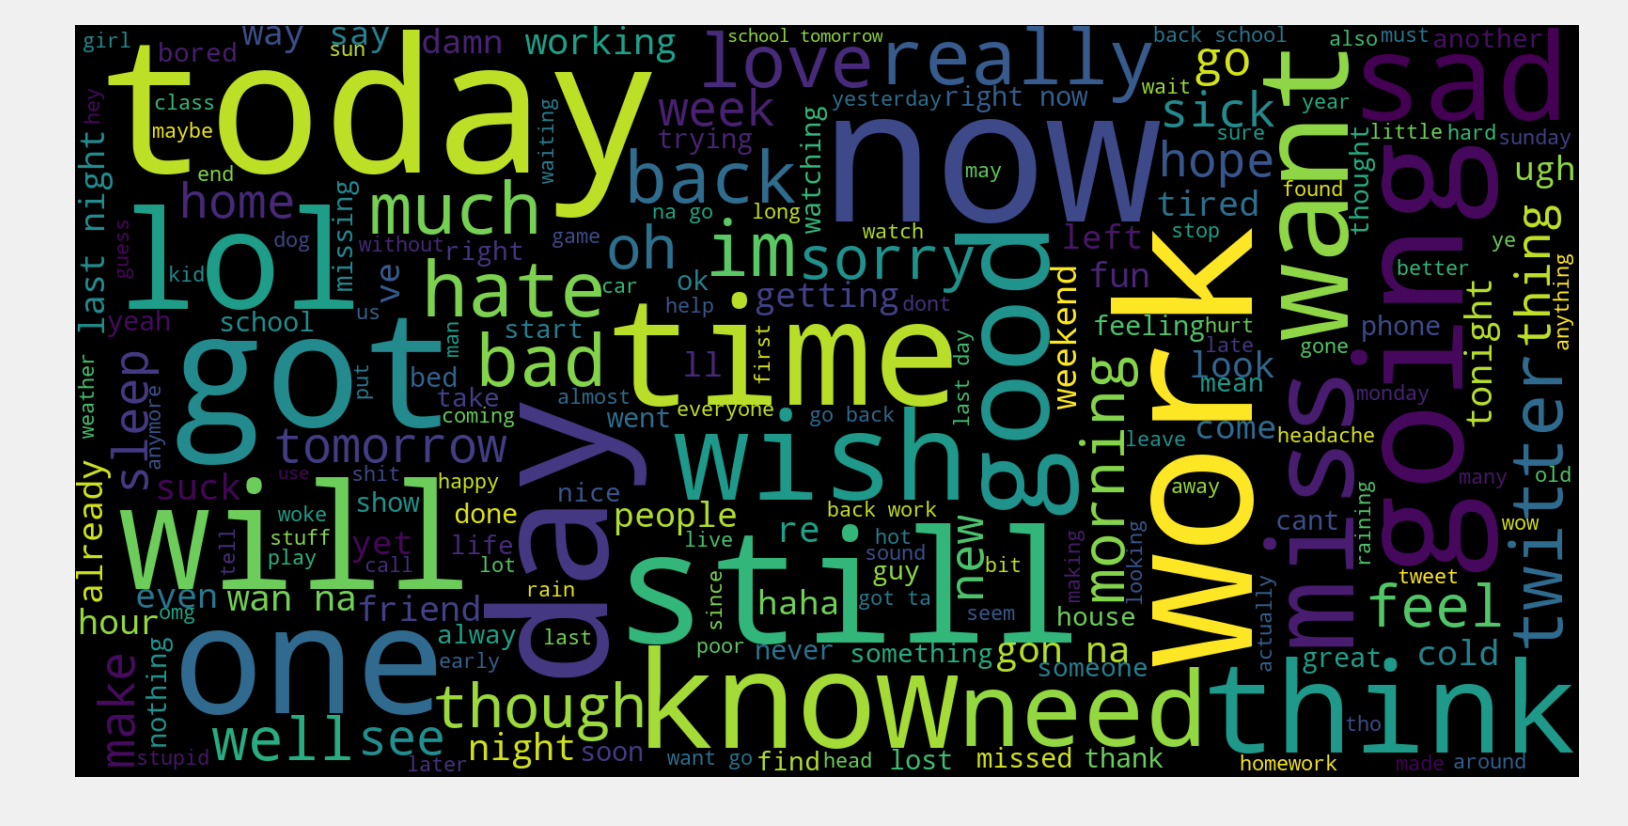

In [27]:
from wordcloud import WordCloud 

wordcloud_neg = WordCloud(width=1600, height=800,max_font_size=200).generate(neg_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud_neg, interpolation="bilinear")
plt.axis("off")
plt.show()

In [28]:
pos_string = []
for t in df_pos.text:
    pos_string.append(t)
pos_string = pd.Series(pos_string).str.cat(sep=' ')

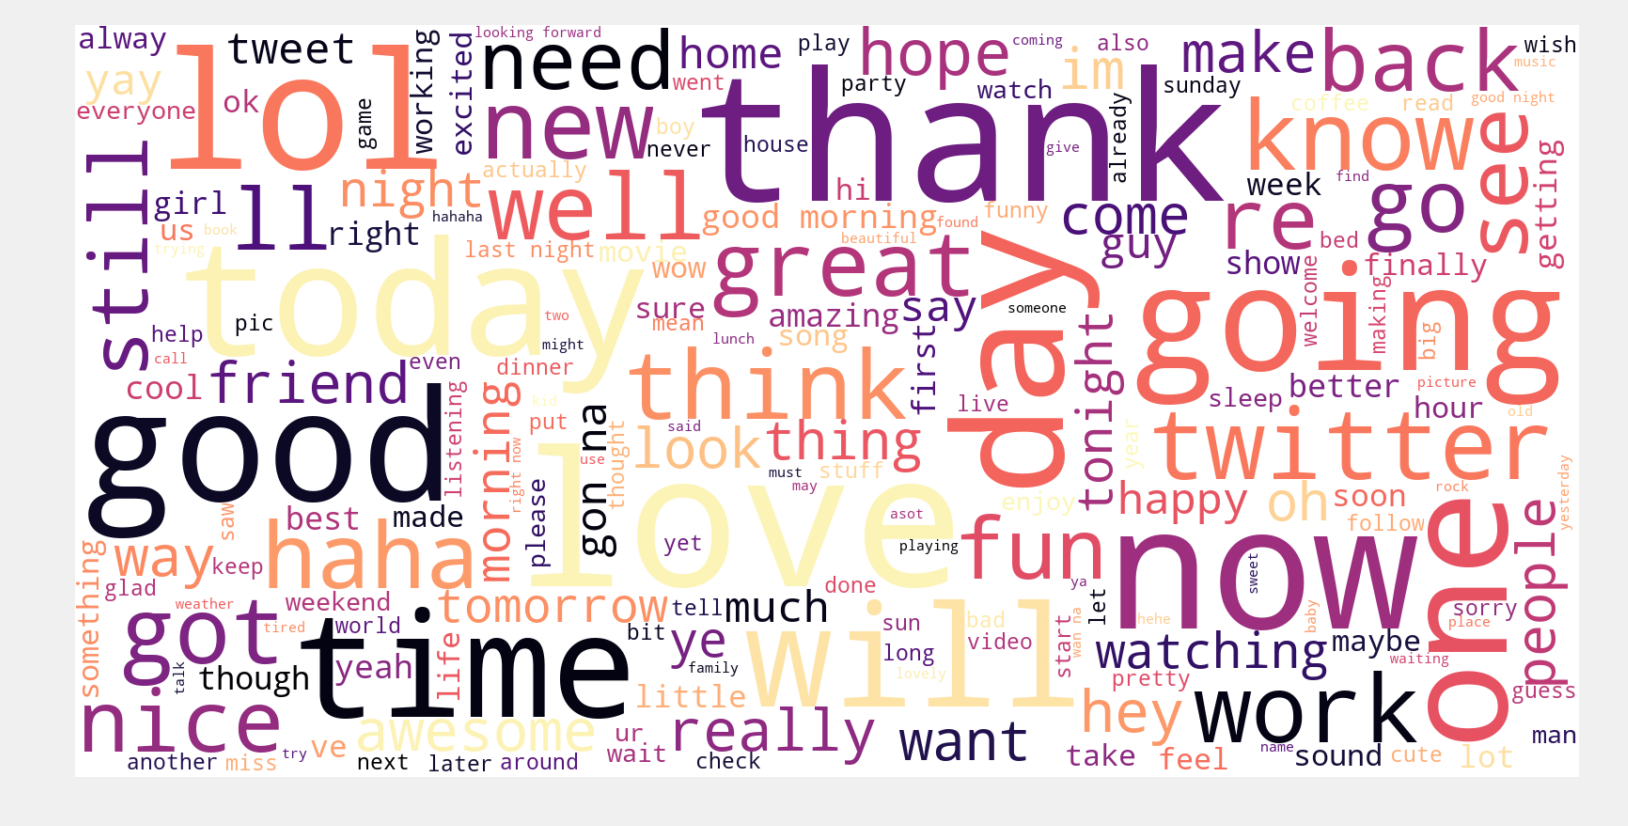

In [29]:
wordcloud_pos = WordCloud(width=1600, height=800,colormap='magma', max_font_size=200,background_color='white').generate(pos_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud_pos, interpolation = "bilinear")
plt.axis("off")
plt.show()

In [30]:
def create_word_features(words):
    my_dict=dict([(word,True) for word in words])
    return my_dict

In [31]:
neg_vec=[]
for string in df_neg.text:
    words=nltk.word_tokenize(string.decode('utf-8'))
    neg_vec.append((create_word_features(words),'negative'))

In [32]:
pos_vec=[]
for string in df_pos.text:
    words=nltk.word_tokenize(string.decode('utf-8'))
    pos_vec.append((create_word_features(words),'positive'))

In [33]:
neg_vec

[({u'a': True,
   u'awww': True,
   u'bummer': True,
   u'carr': True,
   u'd': True,
   u'david': True,
   u'day': True,
   u'do': True,
   u'got': True,
   u'it': True,
   u'of': True,
   u's': True,
   u'shoulda': True,
   u'that': True,
   u'third': True,
   u'to': True,
   u'you': True},
  'negative'),
 ({u'a': True,
   u'also': True,
   u'and': True,
   u'as': True,
   u'blah': True,
   u'by': True,
   u'can': True,
   u'cry': True,
   u'facebook': True,
   u'he': True,
   u'his': True,
   u'is': True,
   u'it': True,
   u'might': True,
   u'not': True,
   u'result': True,
   u'school': True,
   u'texting': True,
   u'that': True,
   u'today': True,
   u'update': True,
   u'upset': True},
  'negative'),
 ({u'ball': True,
   u'bounds': True,
   u'dived': True,
   u'for': True,
   u'go': True,
   u'i': True,
   u'managed': True,
   u'many': True,
   u'of': True,
   u'out': True,
   u'rest': True,
   u'save': True,
   u'the': True,
   u'times': True,
   u'to': True},
  'negative'),


In [34]:
train_set=neg_vec+pos_vec

In [35]:
classifier=NaiveBayesClassifier.train(train_set)

In [36]:
cols = ['sentiment','id','date','query_string','user','text']
df_test = pd.read_csv("test_data.csv",header=None, names=cols,encoding=None)
df_test.head()

,sentiment,id,date,query_string,user,text
0,4,3,Mon May 11 03:17:40 UTC 2009,kindle2,tpryan,@stellargirl I loooooooovvvvvveee my Kindle2. ...
1,4,4,Mon May 11 03:18:03 UTC 2009,kindle2,vcu451,Reading my kindle2... Love it... Lee childs i...
2,4,5,Mon May 11 03:18:54 UTC 2009,kindle2,chadfu,"Ok, first assesment of the #kindle2 ...it fuck..."
3,4,6,Mon May 11 03:19:04 UTC 2009,kindle2,SIX15,@kenburbary You'll love your Kindle2. I've had...
4,4,7,Mon May 11 03:21:41 UTC 2009,kindle2,yamarama,@mikefish Fair enough. But i have the Kindle2...


In [37]:
df_test.drop(['id','date','query_string','user'],axis=1,inplace=True)
df_test.sentiment.value_counts()

4    182
0    177
2    139
Name: sentiment, dtype: int64

In [38]:
negtweets_test=(df_test[df_test.sentiment == 0].text).tolist()
neutweets_test=(df_test[df_test.sentiment == 2].text).tolist() #length is 0
postweets_test=(df_test[df_test.sentiment == 4].text).tolist()

In [39]:
neg_tweet_test=[]
for string in negtweets_test:
    words=nltk.word_tokenize(string.decode('utf-8'))
    neg_tweet_test.append((create_word_features(words),'negative'))

In [40]:
pos_tweet_test=[]
for string in postweets_test:
    words=nltk.word_tokenize(string.decode('utf-8'))
    pos_tweet_test.append((create_word_features(words),'positive'))

In [41]:
test_set=pos_tweet_test+neg_tweet_test

In [42]:
accuracy=nltk.classify.util.accuracy(classifier,test_set)
print accuracy*100

70.7520891365
